![logo](https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/Helmholtz-AI.png?raw=true)

# Dataset: Penguins

In this Notebook we will show you how to analyse and properly preprocess the Penguins dataset. 

--------

## Getting Started

### Setup Colab environment

If you installed the packages and requirments on your own machine, you can skip this section and start from the import section.
Otherwise you can follow and execute the tutorial on your browser. In order to start working on the notebook, click on the following button, this will open this page in the Colab environment and you will be able to execute the code on your own.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/data/datasets_sklearn/Dataset-Penguins.ipynb)



Now that you opened the notebook in Colab, follow the next step:

1. Run this cell to connect your Google Drive to Colab and install packages
2. Allow this notebook to access your Google Drive files. Click on 'Yes', and select your account.
3. "Google Drive for desktop wants to access your Google Account". Click on 'Allow'.
   
At this point, a folder has been created in your Drive and you can navigate it through the lefthand panel in Colab, you might also have received an email that informs you about the access on your Google Drive.

In [1]:
#from google.colab import drive

#drive.mount('/content/drive')

#%cd /content/drive/MyDrive

# Don't run this cell if you already cloned the repo 
#!git clone --branch main https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git
#%cd XAI-Tutorials/data_and_models

### Imports

Let's start with importing all required Python packages.

In [2]:
# Load the required packages
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from palmerpenguins import load_penguins

We fix the random seeds to ensure reproducible results, as we work with (pseudo) random numbers.

In [3]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)

--------

## The Palmer Pinguins Dataset

In this notebook, we will work with the **Palmer Penguins dataset**, containing the information on 3 different species of penguins - Adelie, Chinstrap, and Gentoo - which were observed in the Palmer Archipelago near Palmer Station, Antarctica. The dataset consist of a total of 344 penguings, together with their size measurements, clutch observations, and blood isotope ratios. 

<center><img src="https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/dataset_penguins.png?raw=true" width="500" /></center>

<font size=1> Source: [Link](https://allisonhorst.github.io/palmerpenguins/)

In [4]:
# Load the data
penguins = load_penguins()

### Exploratory Data Analysis

Exploratory data analysis is a first important step to get an understanding of the data and to identify patterns and problems in the data. First, we will check how many samples and variables our dataset has and inspect the first few lines of our dataset:

In [5]:
# Inspect the data
print(f"The dataset has {penguins.shape[1]} variables that describe {penguins.shape[0]} penguins.")
print(f"We have {penguins.select_dtypes(include='object').shape[1]} categorical and {penguins.select_dtypes(exclude='object').shape[1]} numerical variables.")

print("\nHere are the first few lines of our dataset:")
penguins.head()

The dataset has 8 variables that describe 344 penguins.
We have 3 categorical and 5 numerical variables.

Here are the first few lines of our dataset:


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


Next, we check if any values are missing:

In [6]:
print(penguins.isnull().sum())

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
year                  0
dtype: int64


And last, we inspect how our variables are distributed:

/var/folders/g2/lm8kzppj1r35mwcj4zmxsygw0000gn/T/ipykernel_32489/2046816302.py:12: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.countplot(data=penguins, x=col, hue=col, palette=sns.color_palette(palette="Set2", n_colors=3), ax=axs[fig_row, fig_col])


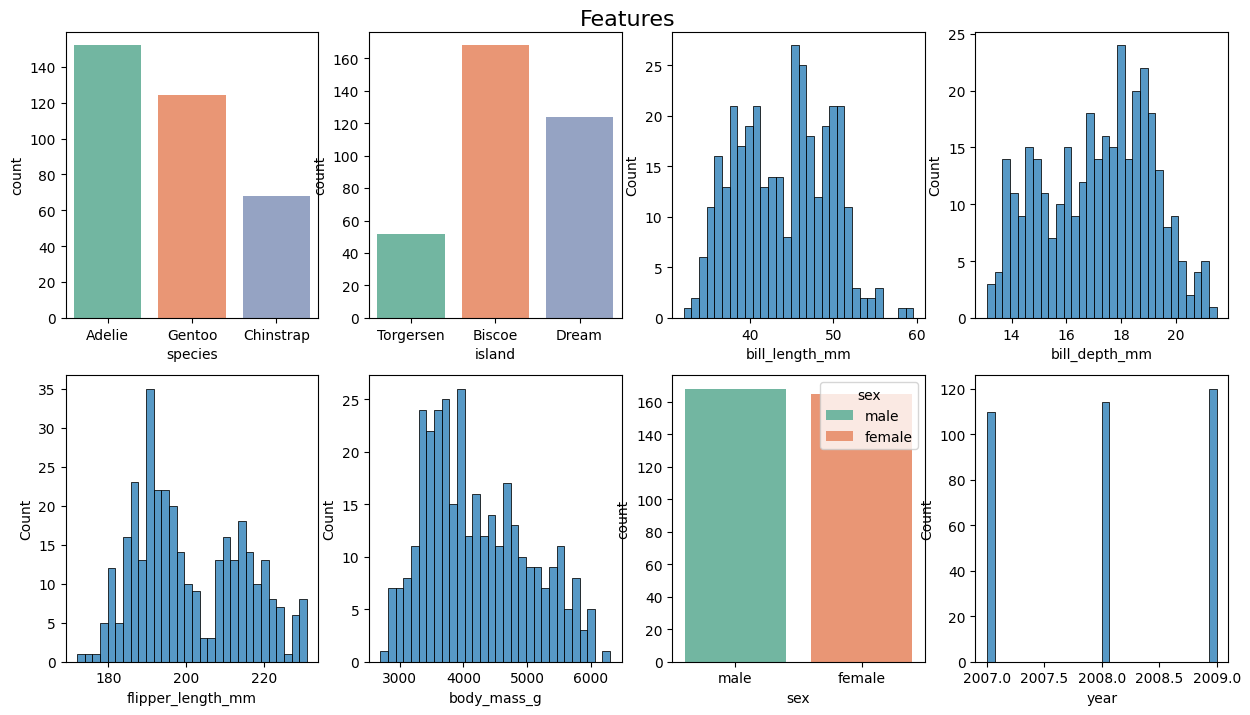

In [7]:
categorical_features = ["species", "island", "sex"]

fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(15, 7.5))
fig.suptitle('Features', fontsize=16)
fig_col = 0
fig_row = 0

for col in penguins.columns:
    if col not in categorical_features:
        sns.histplot(data=penguins, x=col, bins=30, ax=axs[fig_row, fig_col])
    else:
        sns.countplot(data=penguins, x=col, hue=col, palette=sns.color_palette(palette="Set2", n_colors=3), ax=axs[fig_row, fig_col])

    fig_col += 1
    if fig_col == 4:
        fig_col = 0
        fig_row += 1

plt.subplots_adjust(top=0.95) 

By analysing the results of the EDA we can conclude:

- we have missing values in the dataset. There are different options how one can deal with this problem and the chosen strategy depends heavily on the dataset and the context we are in. We can, for example, just omit the cases with missing values (if we do not loose to many samples) or use a missing value imputation method
- we need to encode categorical features because sklearn models usually can't work with string values. These are the features 'island', 'sex', and the target variable 'species'. 

## Data Preprocessing

### Handling of Missing Values 

Based on what we saw in the explorative analysis above, we need to do some preprocessing steps before we start training the model. First, we need to take care of the missing values. There are different options how one can deal with this problem and the strategy one chooses depends heavily on the dataset and the context we are in.

In this example, we will apply the most common approach and simply omit those cases with the missing data and analyse the remaining data. However, be careful with this technique - check how many instances we are left with after the step because the much lower sample number could hinder the training process and we would need to think about other ways to solve the problem, like applying missing data imputation strategies. 

In [8]:
data_penguins = pd.DataFrame(penguins.copy())

# Remove the instances with missing values and check how many we are left with:
print(f"Before omiting the missing values the dataset has {data_penguins.shape[0]} instances")
data_penguins.dropna(inplace=True)
print(f"After omiting the missing values the dataset has {data_penguins.shape[0]} instances")

Before omiting the missing values the dataset has 344 instances
After omiting the missing values the dataset has 333 instances


The new sample size is fully acceptable for the next step. Is our dataset ready to be used for training the model?  
Well...almost! What did we observe regarding feature transformation? Do we need to encode some of them? Yes, we do! 

### Encoding of categorical variables

Categorical features need to be encoded, i.e. turned into numerical data. This is essential because most machine learning models can only interpret numerical data and not data in a text form. As with many data preprocessing steps, there are multiple strategies one can apply to encode the categorical features. 

Here, we will use a simple **dummy encoding** for the categorical features, which will transform the categorical feature values into one-hot encoded vectors. Remeber that our goal is to predict the species of Palmer penguins and hence, our target variable *"Species"* does not need to be encoded, because it will be interepreted as different classes by the Random Forest Classifier.

In [9]:
# preprocess categorical features such that they can be used for the RF model
data_penguins_encoded = pd.get_dummies(data_penguins, columns=['island', 'sex'], prefix=['island', 'sex'], drop_first=True)
data_penguins_encoded.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year,island_Dream,island_Torgersen,sex_male
0,Adelie,39.1,18.7,181.0,3750.0,2007,0,1,1
1,Adelie,39.5,17.4,186.0,3800.0,2007,0,1,0
2,Adelie,40.3,18.0,195.0,3250.0,2007,0,1,0
4,Adelie,36.7,19.3,193.0,3450.0,2007,0,1,0
5,Adelie,39.3,20.6,190.0,3650.0,2007,0,1,1


Note, that the option ``drop_first=True`` leads to k-1 dummies out of k categorical levels by removing the first level. However, it still contains the same amount of information. 

Let's now save the dataset in a ``pickle`` file, such that we can load the preprocessed data into other notebooks later on.

In [10]:
# Save the data with joblib
data = data_penguins_encoded

with open('data_penguins_preprocessed.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)